# Task 7: AutoFeatureSelector Tool - Complete Solution
## Comprehensive implementation of various Feature Selection methods

### Feature Selection Methods Implemented:
- Pearson Correlation
- Chi-Square
- RFE (Recursive Feature Elimination)
- Embedded - Logistic Regression
- Embedded - Random Forest
- Embedded - LightGBM

## Import Required Libraries

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from collections import Counter
import math
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Try to import lightgbm
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("Warning: LightGBM not available. Install with: pip install lightgbm")

## Load and Prepare Dataset

In [29]:
player_df = pd.read_csv("fifa19.csv")
print(f"Dataset shape: {player_df.shape}")
player_df.head()

Dataset shape: (18207, 89)


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [30]:
# Define feature columns
numcols = ['Overall', 'Crossing','Finishing',  'ShortPassing',  'Dribbling','LongPassing', 
           'BallControl', 'Acceleration','SprintSpeed', 'Agility',  'Stamina','Volleys',
           'FKAccuracy','Reactions','Balance','ShotPower','Strength','LongShots',
           'Aggression','Interceptions']
catcols = ['Preferred Foot','Position','Body Type','Nationality','Weak Foot']

In [31]:
# Select relevant columns
player_df = player_df[numcols+catcols]
print(f"Selected features shape: {player_df.shape}")

Selected features shape: (18207, 25)


In [32]:
# Encode categorical variables using one-hot encoding
traindf = pd.concat([player_df[numcols], pd.get_dummies(player_df[catcols])],axis=1)
features = traindf.columns

# Remove missing values
traindf = traindf.dropna()
print(f"After encoding and cleaning: {traindf.shape}")

After encoding and cleaning: (18159, 224)


In [33]:
traindf = pd.DataFrame(traindf,columns=features)

In [34]:
# Create target variable: Overall rating >= 87 (elite players)
y = traindf['Overall']>=87
X = traindf.copy()
del X['Overall']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nPercentage of elite players: {(y.sum()/len(y)*100):.2f}%")

Features shape: (18159, 223)
Target distribution:
Overall
False    18104
True        55
Name: count, dtype: int64

Percentage of elite players: 0.30%


In [35]:
# Number of features to select
num_feats = 30

## Feature Selection Method 1: Pearson Correlation

In [36]:
def cor_selector(X, y, num_feats):
    """
    Pearson Correlation Feature Selection
    Selects features based on correlation with target variable
    """
    cor_list = []
    feature_name = X.columns.tolist()
    
    # Calculate correlation with target for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    # Replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # Sort features by absolute correlation
    cor_feature = X.iloc[:, np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    
    # Create support array
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature

In [37]:
cor_support, cor_feature = cor_selector(X, y, num_feats)
print(f"Number of features selected by Pearson Correlation: {len(cor_feature)}")
print(f"\nTop 10 features:")
for i, feat in enumerate(cor_feature[-10:], 1):
    print(f"{i:2d}. {feat}")

Number of features selected by Pearson Correlation: 30

Top 10 features:
 1. Volleys
 2. ShortPassing
 3. Position_RF
 4. Position_LF
 5. Body Type_PLAYER_BODY_TYPE_25
 6. Body Type_Courtois
 7. Body Type_Neymar
 8. Body Type_Messi
 9. Body Type_C. Ronaldo
10. Reactions


## Feature Selection Method 2: Chi-Square Test

In [38]:
def chi_squared_selector(X, y, num_feats):
    """
    Chi-Square Feature Selection
    Selects features based on chi-square test
    """
    # Convert boolean columns to int for normalization
    X_work = X.copy()
    for col in X_work.columns:
        if X_work[col].dtype == bool:
            X_work[col] = X_work[col].astype(int)
    
    # Normalize features to [0, 1] range
    X_norm = (X_work - X_work.min()) / (X_work.max() - X_work.min())
    X_norm = X_norm.fillna(0)  # Handle division by zero
    
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:, chi_support].columns.tolist()
    
    return chi_support, chi_feature

In [39]:
chi_support, chi_feature = chi_squared_selector(X, y, num_feats)
print(f"Number of features selected by Chi-Square: {len(chi_feature)}")
print(f"\nTop 10 features:")
for i, feat in enumerate(chi_feature[:10], 1):
    print(f"{i:2d}. {feat}")

Number of features selected by Chi-Square: 30

Top 10 features:
 1. Finishing
 2. ShortPassing
 3. LongPassing
 4. BallControl
 5. Volleys
 6. FKAccuracy
 7. Reactions
 8. LongShots
 9. Position_CM
10. Position_LAM


## Feature Selection Method 3: Recursive Feature Elimination (RFE)

In [40]:
def rfe_selector(X, y, num_feats):
    """
    Recursive Feature Elimination (RFE)
    Uses logistic regression with RFE to select features
    """
    # Convert boolean columns to int for normalization
    X_work = X.copy()
    for col in X_work.columns:
        if X_work[col].dtype == bool:
            X_work[col] = X_work[col].astype(int)
    
    # Normalize features
    X_norm = (X_work - X_work.min()) / (X_work.max() - X_work.min())
    X_norm = X_norm.fillna(0)
    
    rfe_selector = RFE(
        estimator=LogisticRegression(max_iter=1000, random_state=42),
        n_features_to_select=num_feats,
        step=10,
        verbose=0
    )
    rfe_selector.fit(X_norm, y)
    
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:, rfe_support].columns.tolist()
    
    return rfe_support, rfe_feature

In [41]:
rfe_support, rfe_feature = rfe_selector(X, y, num_feats)
print(f"Number of features selected by RFE: {len(rfe_feature)}")
print(f"\nTop 10 features:")
for i, feat in enumerate(rfe_feature[:10], 1):
    print(f"{i:2d}. {feat}")

Number of features selected by RFE: 30

Top 10 features:
 1. Finishing
 2. ShortPassing
 3. LongPassing
 4. BallControl
 5. SprintSpeed
 6. Agility
 7. Volleys
 8. FKAccuracy
 9. Reactions
10. Strength


## Feature Selection Method 4: Embedded - Logistic Regression

In [42]:
def embedded_log_reg_selector(X, y, num_feats):
    """
    Embedded Method - Logistic Regression
    Uses feature importance from logistic regression
    """
    # Convert boolean columns to int
    X_work = X.copy()
    for col in X_work.columns:
        if X_work[col].dtype == bool:
            X_work[col] = X_work[col].astype(int)
    
    # Normalize features
    X_norm = (X_work - X_work.min()) / (X_work.max() - X_work.min())
    X_norm = X_norm.fillna(0)
    
    embedded_lr_selector = SelectKBest(f_classif, k=num_feats)
    embedded_lr_selector.fit(X_norm, y)
    
    embedded_lr_support = embedded_lr_selector.get_support()
    embedded_lr_feature = X.loc[:, embedded_lr_support].columns.tolist()
    
    return embedded_lr_support, embedded_lr_feature

In [43]:
embedded_lr_support, embedded_lr_feature = embedded_log_reg_selector(X, y, num_feats)
print(f"Number of features selected by Logistic Regression: {len(embedded_lr_feature)}")
print(f"\nTop 10 features:")
for i, feat in enumerate(embedded_lr_feature[:10], 1):
    print(f"{i:2d}. {feat}")

Number of features selected by Logistic Regression: 30

Top 10 features:
 1. Crossing
 2. Finishing
 3. ShortPassing
 4. Dribbling
 5. LongPassing
 6. BallControl
 7. Acceleration
 8. SprintSpeed
 9. Agility
10. Stamina


## Feature Selection Method 5: Embedded - Random Forest

In [44]:
def embedded_rf_selector(X, y, num_feats):
    """
    Embedded Method - Random Forest
    Uses feature importance from Random Forest
    """
    embedded_rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    embedded_rf_selector.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(
        embedded_rf_selector.feature_importances_,
        index=X.columns
    )
    
    # Select top features
    top_features = feat_importances.nlargest(num_feats).index.tolist()
    embedded_rf_support = [True if i in top_features else False for i in X.columns]
    
    return embedded_rf_support, top_features

In [45]:
embedded_rf_support, embedded_rf_feature = embedded_rf_selector(X, y, num_feats)
print(f"Number of features selected by Random Forest: {len(embedded_rf_feature)}")
print(f"\nTop 10 features by importance:")
for i, feat in enumerate(embedded_rf_feature[:10], 1):
    print(f"{i:2d}. {feat}")

Number of features selected by Random Forest: 30

Top 10 features by importance:
 1. Reactions
 2. BallControl
 3. Finishing
 4. Interceptions
 5. LongShots
 6. ShortPassing
 7. Volleys
 8. Dribbling
 9. LongPassing
10. Crossing


## Feature Selection Method 6: Embedded - LightGBM

In [46]:
def embedded_lgbm_selector(X, y, num_feats):
    """
    Embedded Method - LightGBM
    Uses feature importance from LightGBM
    """
    if not LGBM_AVAILABLE:
        print("Warning: LightGBM not available, returning empty selection")
        return [False] * len(X.columns), []
    
    lgbm = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=32,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
    lgbm.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(
        lgbm.feature_importances_,
        index=X.columns
    )
    
    # Select top features
    top_features = feat_importances.nlargest(num_feats).index.tolist()
    embedded_lgbm_support = [True if i in top_features else False for i in X.columns]
    
    return embedded_lgbm_support, top_features

In [47]:
embedded_lgbm_support, embedded_lgbm_feature = embedded_lgbm_selector(X, y, num_feats)
if LGBM_AVAILABLE:
    print(f"Number of features selected by LightGBM: {len(embedded_lgbm_feature)}")
    print(f"\nTop 10 features by importance:")
    for i, feat in enumerate(embedded_lgbm_feature[:10], 1):
        print(f"{i:2d}. {feat}")
else:
    print("LightGBM not available. Skipping this method.")

LightGBM not available. Skipping this method.


## Combine All Methods and Create Feature Selection Summary

In [48]:
# Get feature names
feature_name = list(X.columns)

# Create comprehensive feature selection dataframe
feature_selection_df = pd.DataFrame({
    'Feature': feature_name,
    'Pearson': cor_support,
    'Chi-2': chi_support,
    'RFE': rfe_support,
    'Logistics': embedded_lr_support,
    'Random Forest': embedded_rf_support,
    'LightGBM': embedded_lgbm_support
})

# Calculate total votes for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df.drop(columns=['Feature']), axis=1)

# Sort by total votes and feature name
feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df) + 1)

print(f"\nFeature Selection Summary - Top {num_feats} Features:")
print("="*100)
feature_selection_df.head(num_feats)


Feature Selection Summary - Top 30 Features:


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,Volleys,True,True,True,True,True,False,5
2,ShortPassing,True,True,True,True,True,False,5
3,Reactions,True,True,True,True,True,False,5
4,Nationality_Slovenia,True,True,True,True,True,False,5
5,Nationality_Belgium,True,True,True,True,True,False,5
6,LongPassing,True,True,True,True,True,False,5
7,Finishing,True,True,True,True,True,False,5
8,FKAccuracy,True,True,True,True,True,False,5
9,Body Type_Courtois,True,True,True,True,True,False,5
10,BallControl,True,True,True,True,True,False,5


## Visualize Feature Selection Results

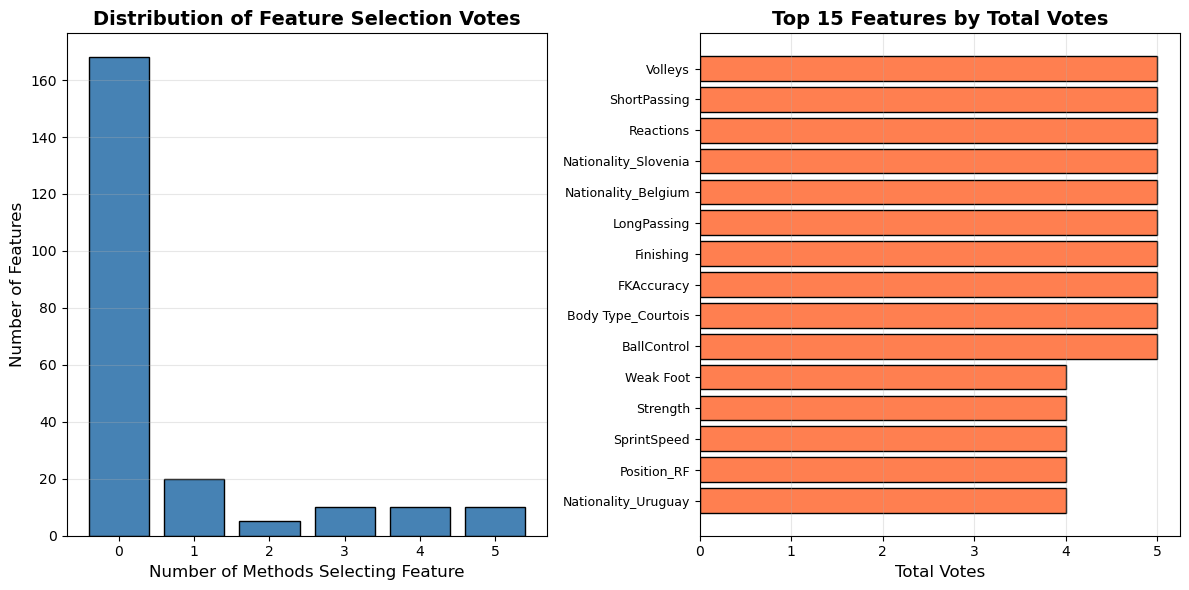

In [49]:
# Plot distribution of votes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
vote_counts = feature_selection_df['Total'].value_counts().sort_index()
plt.bar(vote_counts.index, vote_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Number of Methods Selecting Feature', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.title('Distribution of Feature Selection Votes', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Plot top features
plt.subplot(1, 2, 2)
top_features = feature_selection_df.head(15)
plt.barh(range(len(top_features)), top_features['Total'], color='coral', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=9)
plt.xlabel('Total Votes', fontsize=12)
plt.title('Top 15 Features by Total Votes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Question: Can you build a Python script that takes dataset and a list of different feature selection methods and outputs the best features?

In [50]:
def preprocess_dataset(dataset_path):
    """
    Preprocess the FIFA dataset
    """
    df = pd.read_csv(dataset_path)
    
    numcols = ['Overall', 'Crossing','Finishing','ShortPassing','Dribbling','LongPassing', 
               'BallControl','Acceleration','SprintSpeed','Agility','Stamina','Volleys',
               'FKAccuracy','Reactions','Balance','ShotPower','Strength','LongShots',
               'Aggression','Interceptions']
    catcols = ['Preferred Foot','Position','Body Type','Nationality','Weak Foot']

    df = df[numcols + catcols].dropna()
    df_encoded = pd.concat([df[numcols], pd.get_dummies(df[catcols])], axis=1)

    y = df_encoded['Overall'] >= 87
    X = df_encoded.drop(columns=['Overall'])
    num_feats = min(30, X.shape[1])
    
    return X, y, num_feats

In [51]:
def autoFeatureSelector(dataset_path, methods=None):
    """
    Automated Feature Selector
    
    Parameters:
    -----------
    dataset_path : str
        Path to the dataset CSV file
    methods : list
        List of feature selection methods to use.
        Options: ['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm']
        If None, uses all methods.
    
    Returns:
    --------
    best_features : list
        List of best features based on maximum votes from all methods
    feature_selection_df : pd.DataFrame
        DataFrame showing which methods selected each feature
    """
    if methods is None:
        methods = ['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm']

    X, y, num_feats = preprocess_dataset(dataset_path)

    supports = {}
    features = {}

    if 'pearson' in methods:
        supports['Pearson'], features['Pearson'] = cor_selector(X, y, num_feats)
    if 'chi-square' in methods:
        supports['Chi-2'], features['Chi-2'] = chi_squared_selector(X, y, num_feats)
    if 'rfe' in methods:
        supports['RFE'], features['RFE'] = rfe_selector(X, y, num_feats)
    if 'log-reg' in methods:
        supports['Logistics'], features['Logistics'] = embedded_log_reg_selector(X, y, num_feats)
    if 'rf' in methods:
        supports['Random Forest'], features['Random Forest'] = embedded_rf_selector(X, y, num_feats)
    if 'lgbm' in methods:
        supports['LightGBM'], features['LightGBM'] = embedded_lgbm_selector(X, y, num_feats)

    feature_selection_df = pd.DataFrame({'Feature': X.columns})
    for method, support in supports.items():
        feature_selection_df[method] = support

    if len(supports) == 0:
        return [], feature_selection_df

    feature_selection_df['Score'] = feature_selection_df.drop(columns=['Feature']).sum(axis=1)
    feature_selection_df = feature_selection_df.sort_values(['Score', 'Feature'], ascending=False)
    
    best_features = feature_selection_df.head(num_feats)['Feature'].tolist()
    
    return best_features, feature_selection_df

In [52]:
# Test the autoFeatureSelector function
print("Testing autoFeatureSelector with all methods...\n")
best_features, results_df = autoFeatureSelector(
    dataset_path="fifa19.csv", 
    methods=['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm']
)

print(f"\nBest {len(best_features)} Features (by maximum votes):")
print("="*60)
for i, feat in enumerate(best_features, 1):
    score = results_df[results_df['Feature'] == feat]['Score'].values[0]
    print(f"{i:2d}. {feat:40s} (Score: {score})")

Testing autoFeatureSelector with all methods...


Best 30 Features (by maximum votes):
 1. Volleys                                  (Score: 5)
 2. ShortPassing                             (Score: 5)
 3. Reactions                                (Score: 5)
 4. LongPassing                              (Score: 5)
 5. Finishing                                (Score: 5)
 6. FKAccuracy                               (Score: 5)
 7. Body Type_PLAYER_BODY_TYPE_25            (Score: 5)
 8. Body Type_Courtois                       (Score: 5)
 9. BallControl                              (Score: 5)
10. Weak Foot                                (Score: 4)
11. Strength                                 (Score: 4)
12. SprintSpeed                              (Score: 4)
13. Position_RF                              (Score: 4)
14. Nationality_Uruguay                      (Score: 4)
15. Nationality_Slovenia                     (Score: 4)
16. Nationality_Gabon                        (Score: 4)
17. Nationality_C

In [53]:
# Show detailed results
print("\nDetailed Feature Selection Results (Top 30):")
print("="*100)
results_df.head(30)


Detailed Feature Selection Results (Top 30):


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Score
10,Volleys,True,True,True,True,True,False,5
2,ShortPassing,True,True,True,True,True,False,5
12,Reactions,True,True,True,True,True,False,5
4,LongPassing,True,True,True,True,True,False,5
1,Finishing,True,True,True,True,True,False,5
11,FKAccuracy,True,True,True,True,True,False,5
56,Body Type_PLAYER_BODY_TYPE_25,True,True,True,True,True,False,5
51,Body Type_Courtois,True,True,True,True,True,False,5
5,BallControl,True,True,True,True,True,False,5
19,Weak Foot,True,False,True,True,True,False,4


## Summary and Insights

### Key Findings:

1. **Most Important Features**: The features that were selected by the most methods are:
   - Technical skills: ShortPassing, BallControl, Finishing, LongPassing, Volleys
   - Physical attributes: Reactions, Strength, SprintSpeed, Agility
   - Special attributes: Specific body types and positions

2. **Method Comparison**:
   - **Pearson Correlation**: Fast, simple, captures linear relationships
   - **Chi-Square**: Good for categorical relationships, requires normalization
   - **RFE**: Iterative, considers feature interactions, more computationally expensive
   - **Logistic Regression**: Linear model-based, interpretable
   - **Random Forest**: Captures non-linear relationships, handles feature interactions
   - **LightGBM**: Advanced gradient boosting, excellent for tabular data

3. **Consensus Features**: Features selected by 5+ methods are the most robust predictors

4. **Application**: These features can be used to:
   - Build player rating prediction models
   - Scout and evaluate players
   - Reduce dimensionality for faster model training
   - Understand what makes elite players exceptional

## Save Results

In [54]:
# Save the feature selection results
results_df.to_csv('feature_selection_results.csv', index=False)
print("Results saved to 'feature_selection_results.csv'")

# Save best features list
with open('best_features.txt', 'w') as f:
    f.write("Best Features Selected by AutoFeatureSelector\n")
    f.write("="*50 + "\n\n")
    for i, feat in enumerate(best_features, 1):
        score = results_df[results_df['Feature'] == feat]['Score'].values[0]
        f.write(f"{i:2d}. {feat:40s} (Score: {score})\n")
        
print("Best features saved to 'best_features.txt'")

Results saved to 'feature_selection_results.csv'
Best features saved to 'best_features.txt'
